<p align = "center"><strong>LOCAL SPATIAL AUTOCORRELATION: GEARY I <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Multiple Geary Local__

__Def.__  

Medida **local de autocorrelación espacial** que cuantifica el grado de **disimilitud espacial** entre los valores de **múltiples variables** observadas en unidades espaciales vecinas, de acuerdo con una matriz de pesos espaciales.  
El índice local de Geary multivariante evalúa simultáneamente el comportamiento de **2 o más variables**, detectando regiones donde el **perfil multivariante** es similar o disímil al de sus vecinos.

El índice toma los siguientes valores:
- $\to$ __Valores bajos__ (cercanos a 0) indican fuerte autocorrelación espacial positiva (perfiles multivariantes **similares** entre vecinos),
- $\to$ __Valores altos__ (alejados de la media) indican autocorrelación espacial negativa (perfiles multivariantes **disímiles** entre vecinos).

__Formula:__

Sea $\mathbf{X}$ una matriz de $n$ observaciones y $m$ variables:

$$
\mathbf{X} = \begin{bmatrix}
x_{11} & x_{12} & \cdots & x_{1m} \\
x_{21} & x_{22} & \cdots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{nm}
\end{bmatrix}
$$

Para cada ubicación $i$, definimos el vector de atributos multivariante:
$$
\mathbf{X}_i = [x_{i1}, x_{i2}, ..., x_{im}]
$$

**Distancia Euclidiana al cuadrado** en el espacio de atributos entre $i$ y $j$:
$$
d_{ij}^2 = \sum_{k=1}^{m} (x_{ik} - x_{jk})^2
$$

**Índice Local de Geary Multivariante**:
$$
C_i^{mv} = \sum_{j=1}^{n} w_{ij} \cdot d_{ij}^2 = \sum_{j=1}^{n} w_{ij} \sum_{k=1}^{m} (x_{ik} - x_{jk})^2
$$

<p align='center'> 
<em>El índice local de Geary multivariante evalúa la autocorrelación espacial a partir de las diferencias cuadráticas en el espacio de atributos entre unidades vecinas, considerando simultáneamente todas las variables de interés.</em>
</p>

donde:
- $w_{ij}$: elemento de la matriz de pesos espaciales $W$ (usualmente normalizada por filas),
- $x_{ik}$: valor observado de la variable $k$ en la unidad espacial $i$,
- $x_{jk}$: valor observado de la variable $k$ en la unidad espacial $j$ (vecina de $i$),
- $n$: número de unidades espaciales,
- $m$: número de variables.

__Referencias:__
- Anselin, L. (2019). *A Local Indicator of Multivariate Spatial Association: Extending Geary's c*. Geographical Analysis, 51(2), 133-150.  
  https://onlinelibrary.wiley.com/doi/abs/10.1111/gean.12164
- Geary, R. C. (1954). *The contiguity ratio and statistical mapping*. The Incorporated Statistician, 5(3), 115–145.  
  https://www.jstor.org/stable/2986645

In [2]:
# DEPENDENCIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import geopandas as gpd
from libpysal.weights import Queen, Rook, W, lag_spatial
import warnings

from scipy import stats


def local_geary_mv(
    gdf,
    fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize: bool = True,
    use_index: bool = True,
    figsize=(18, 12),
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
):
    """
    Local Geary Multivariante para múltiples variables y 3 contigüidades (Queen/Rook/Bishop).
    
    Calcula el estadístico Local Geary Multivariante:
    c_i^mv = sum_j w_ij * sum_k (x_ik - x_jk)^2
    
    Donde k = 1,...,m variables.
    
    Returns:
      - results_table: tabla con estadísticos globales y conteos Local Geary MV (por conjunto de variables x contiguity)
      - fig: Dashboard con:
             (1) Distribución del estadístico
             (2) Local Geary MV significance map (p bins)
             (3) Local Geary MV cluster map (Similar, Disimilar)
             repetido para cada contigüidad (rows)
      - out: dict con objetos detallados
    """

    # -------------------------
    # BASIC INPUT HANDLING
    # -------------------------
    if isinstance(fields, str):
        fields = [fields]
    
    fields = list(fields)
    
    if len(fields) < 2:
        raise ValueError("Se requieren al menos 2 variables para Geary Local Multivariante.")
    
    # validate columns
    missing = [c for c in fields if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")
    
    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")
    
    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )
    
    # -------------------------
    # PLOT STYLE AND WARNING HANDLING
    # -------------------------
    plt.style.use(style)
    
    if silence_warnings:
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message=".*weights matrix is not fully connected.*",
        )
        warnings.filterwarnings(
            "ignore",
            category=FutureWarning,
            message=".*use_index.*",
        )
    
    # -------------------------
    # HELPER: BUILD SPATIAL WEIGHTS
    # -------------------------
    def build_w(df, kind):
        """
        Build a spatial weights object for a given contiguity type:
          - queen  : shared edge OR vertex
          - rook   : shared edge
          - bishop : shared vertex only (queen minus rook)
        """
        if kind == "queen":
            return Queen.from_dataframe(df, use_index=use_index)
        
        if kind == "rook":
            return Rook.from_dataframe(df, use_index=use_index)
        
        if kind == "bishop":
            wq = Queen.from_dataframe(df, use_index=use_index)
            wr = Rook.from_dataframe(df, use_index=use_index)
            
            ids = list(wq.id_order)
            neighbors = {}
            for i in ids:
                nq = set(wq.neighbors.get(i, []))
                nr = set(wr.neighbors.get(i, []))
                neighbors[i] = list(nq - nr)  # vertex-only adjacency
            
            return W(neighbors, id_order=ids)
        
        raise ValueError("kind must be queen/rook/bishop")
    
    # -------------------------
    # HELPER: Z-SCORE STANDARIZATION
    # -------------------------
    def zscore(v):
        v = np.asarray(v, dtype=float)
        sd = v.std(ddof=0)
        return (v - v.mean()) / sd if sd > 0 else v * 0.0
    
    # -------------------------
    # HELPER: CALCULAR GEARY LOCAL MULTIVARIANTE
    # -------------------------
    def calc_geary_local_mv(X, w):
        """
        Calcula el estadístico Local Geary Multivariante.
        
        Parameters
        ----------
        X : ndarray (n, m)
            Matriz de variables estandarizadas.
        w : libpysal.weights.W
            Objeto de pesos espaciales (transformado a 'R').
            
        Returns
        -------
        geary_local : ndarray (n,)
            Estadístico Local Geary Multivariante.
        """
        n, m = X.shape
        geary_local = np.zeros(n)
        
        # Obtener matriz de pesos en formato denso
        w_matrix = w.full()[0]
        
        for i in range(n):
            # Distancia euclidiana al cuadrado entre i y todos los j
            diff = X[i, :] - X  # (n, m)
            sq_dist = np.sum(diff**2, axis=1)  # (n,)
            
            # Multiplicar por pesos y sumar
            geary_local[i] = np.sum(w_matrix[i, :] * sq_dist)
        
        return geary_local
    
    # -------------------------
    # HELPER: SIMULACIÓN (PERMUTACIONES)
    # -------------------------
    def simulate_geary_local_mv(X, w, permutations, seed=None):
        """
        Realiza permutaciones condicionales para obtener la distribución nula.
        
        Returns
        -------
        geary_obs : ndarray (n,)
            Estadístico observado.
        geary_sim : ndarray (n, permutations)
            Valores simulados.
        p_sim : ndarray (n,)
            Pseudo p-valores (cola inferior).
        """
        np.random.seed(seed)
        n, m = X.shape
        geary_obs = calc_geary_local_mv(X, w)
        geary_sim = np.zeros((n, permutations))
        
        # Matriz de pesos en formato denso (una vez)
        w_matrix = w.full()[0]
        
        for i in range(n):
            for perm in range(permutations):
                # Índices para permutar (todos excepto i)
                idx = np.arange(n)
                idx = idx[idx != i]
                perm_idx = np.random.permutation(idx)
                
                # Crear matriz permutada
                X_perm = X.copy()
                X_perm[idx, :] = X[perm_idx, :]
                
                # Calcular estadístico para i
                diff = X_perm[i, :] - X_perm
                sq_dist = np.sum(diff**2, axis=1)
                geary_sim[i, perm] = np.sum(w_matrix[i, :] * sq_dist)
        
        # Pseudo p-valores (cola inferior: valores pequeños indican similitud)
        p_sim = np.zeros(n)
        for i in range(n):
            count_lower = np.sum(geary_sim[i, :] <= geary_obs[i])
            p_sim[i] = (count_lower + 1) / (permutations + 1)
        
        return geary_obs, geary_sim, p_sim
    
    # -------------------------
    # PRECOMPUTE (BY CONTIGUITY) : WEIGHTS + ISLAND HANDLING ONCE
    # -------------------------
    kinds = list(contiguities)
    by_kind = {}
    
    for kind in kinds:
        df2 = gdf.copy()
        
        # Build weights on the full GeoDataFrame
        w = build_w(df2, kind)
        islands_initial = list(getattr(w, "islands", []))
        
        # Optionally drop islands and rebuild weights
        if drop_islands and len(islands_initial) > 0:
            df2 = df2.drop(index=islands_initial).copy() if use_index else df2.copy()
            w = build_w(df2, kind)
        
        # Row-standardize weights (Geoda convention)
        w.transform = "R"
        
        by_kind[kind] = {
            "gdf": df2,
            "w": w,
            "islands_initial": islands_initial,
        }
    
    # -------------------------
    # RESULTS TABLE
    # -------------------------
    rows = []
    
    # Crear identificador para el conjunto de variables
    var_str = ", ".join(fields)
    
    for kind in kinds:
        df2 = by_kind[kind]["gdf"]
        w = by_kind[kind]["w"]
        islands_initial = by_kind[kind]["islands_initial"]
        
        # Extraer variables
        X = np.column_stack([df2[field].to_numpy() for field in fields])
        n = X.shape[0]
        m = X.shape[1]
        
        # Degenerate cases: too few observations or zero variance en alguna variable
        has_zero_var = any(np.std(X[:, k], ddof=0) == 0 for k in range(m))
        
        if n < 3 or has_zero_var:
            rows.append({
                "variables": var_str,
                "contiguity": kind.upper(),
                "n": int(n),
                "n_vars": int(m),
                "global_Geary_mv": np.nan,
                "permutations": int(permutations),
                "alpha": float(alpha),
                "islands_initial": int(len(islands_initial)),
                "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                "islands_remaining": int(len(getattr(w, "islands", []))),
                "sig_0_not": np.nan,
                "sig_1_p05": np.nan,
                "sig_2_p01": np.nan,
                "sig_3_p001": np.nan,
                "Similar": np.nan,
                "Disimilar": np.nan,
                "note": "n<3 or zero variance in some variable",
            })
            continue
        
        # Estandarizar si es necesario
        if standardize:
            X_std = np.column_stack([zscore(X[:, k]) for k in range(m)])
        else:
            X_std = X.copy()
        
        # Calcular Geary Local Multivariante
        geary_obs, geary_sim, p_sim = simulate_geary_local_mv(X_std, w, permutations)
        
        # Estadístico global (promedio de los locales)
        global_geary = np.mean(geary_obs)
        
        # Significance classes: 
        # 0 = Not significant, 1 = p <= 0.05, 2 = p <= 0.01, 3 = p <= 0.001
        sig_class = np.zeros_like(p_sim, dtype=int)
        sig_class[(p_sim <= 0.05) & (p_sim > 0.01)] = 1
        sig_class[(p_sim <= 0.01) & (p_sim > 0.001)] = 2
        sig_class[p_sim <= 0.001] = 3
        
        sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)
        
        # Cluster classes:
        # 1 = Similar (significativo y geary < media)
        # 2 = Disimilar (significativo y geary > media)
        # 0 = No significativo
        cl_class = np.zeros_like(p_sim, dtype=int)
        sig_alpha = p_sim <= alpha
        mean_geary = np.mean(geary_obs)
        
        cl_class[sig_alpha & (geary_obs < mean_geary)] = 1  # Similar
        cl_class[sig_alpha & (geary_obs >= mean_geary)] = 2  # Disimilar
        
        cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2], fill_value=0)
        
        # Guardar objetos para el output
        if kind not in by_kind[kind]:
            by_kind[kind].update({
                "X_std": X_std,
                "geary_obs": geary_obs,
                "geary_sim": geary_sim,
                "p_sim": p_sim,
                "sig_class": sig_class,
                "cl_class": cl_class,
                "global_geary": global_geary,
            })
        
        rows.append({
            "variables": var_str,
            "contiguity": kind.upper(),
            "n": int(n),
            "n_vars": int(m),
            "global_Geary_mv": float(global_geary),
            "permutations": int(permutations),
            "alpha": float(alpha),
            "islands_initial": int(len(islands_initial)),
            "islands_removed": int(len(islands_initial)) if drop_islands else 0,
            "islands_remaining": int(len(getattr(w, "islands", []))),
            "sig_0_not": int(sig_counts[0]),
            "sig_1_p05": int(sig_counts[1]),
            "sig_2_p01": int(sig_counts[2]),
            "sig_3_p001": int(sig_counts[3]),
            "Similar": int(cl_counts[1]),
            "Disimilar": int(cl_counts[2]),
            "note": "",
        })
    
    results_table = pd.DataFrame(rows)
    
    # Force contiguity ordering
    order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
    results_table["contiguity"] = results_table["contiguity"].astype(str).str.upper().astype(order)
    results_table = results_table.sort_values(["variables", "contiguity"]).reset_index(drop=True)
    
    # -------------------------
    # DASHBOARD palettes + legends (MISMO ESTILO QUE local_moran)
    # -------------------------
    # Significance colors (exactamente igual que en local_moran)
    sig_labels = ["Not Significant", "p ≤ 0.05", "p ≤ 0.01", "p ≤ 0.001"]
    sig_colors = ["#f0f0f0", "#a1d99b", "#41ab5d", "#005a32"]
    sig_cmap = ListedColormap(sig_colors)
    
    # Cluster colors - Adaptado para Geary MV (Similar/Disimilar)
    # Usamos azul para Similar (como LL en Moran) y rojo para Disimilar (como HH en Moran)
    cl_labels = ["Not Significant", "Similar", "Disimilar"]
    cl_colors = ["#f0f0f0", "#377eb8", "#e41a1c"]  # Azul = Similar, Rojo = Disimilar
    cl_cmap = ListedColormap(cl_colors)
    
    # -------------------------
    # DASHBOARD para el conjunto de variables
    # -------------------------
    out = {"variables": var_str, "by_contiguity": {}}
    
    # Figure: rows = contiguities, cols = (distribution, significance, cluster)
    fig, axes = plt.subplots(len(kinds), 3, figsize=figsize)
    if len(kinds) == 1:
        axes = np.array([axes])
    
    for r, kind in enumerate(kinds):
        df2 = by_kind[kind]["gdf"]
        w = by_kind[kind]["w"]
        islands_initial = by_kind[kind]["islands_initial"]
        
        X_std = by_kind[kind]["X_std"]
        geary_obs = by_kind[kind]["geary_obs"]
        geary_sim = by_kind[kind]["geary_sim"]
        p_sim = by_kind[kind]["p_sim"]
        sig_class = by_kind[kind]["sig_class"]
        cl_class = by_kind[kind]["cl_class"]
        global_geary = by_kind[kind]["global_geary"]
        
        # 1. Distribución del estadístico (histograma + valor observado)
        ax_dist = axes[r, 0]
        
        # Aplanar todas las simulaciones para el histograma
        all_sim = geary_sim.flatten()
        ax_dist.hist(all_sim, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax_dist.axvline(global_geary, color='red', linewidth=2, linestyle='--', label=f'Global mean: {global_geary:.3f}')
        ax_dist.set_xlabel('Local Geary MV')
        ax_dist.set_ylabel('Frequency')
        ax_dist.set_title(f'{kind.upper()} — Distribution of Local Geary MV\n(Global mean = {global_geary:.3f})', fontweight='bold')
        ax_dist.legend()
        
        # Conteos de significancia
        sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)
        
        gdf_plot = df2.copy()
        gdf_plot["_sig_class"] = sig_class
        gdf_plot["_cl_class"] = cl_class
        
        # 2. Significance map
        ax_sig = axes[r, 1]
        gdf_plot.plot(
            column="_sig_class",
            categorical=True,
            cmap=sig_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_sig,
        )
        ax_sig.set_axis_off()
        ax_sig.set_title(
            f"{kind.upper()} — Local Geary MV Significance (perms={permutations})",
            fontweight='bold'
        )
        
        sig_legend = [
            Patch(facecolor=sig_colors[i], edgecolor="k", 
                  label=f"{sig_labels[i]} ({int(sig_counts[i])})")
            for i in range(4)
        ]
        ax_sig.legend(handles=sig_legend, loc="lower left", frameon=True)
        
        # 3. Cluster map 
        ax_cl = axes[r, 2]
        gdf_plot.plot(
            column="_cl_class",
            categorical=True,
            cmap=cl_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_cl,
        )
        ax_cl.set_axis_off()
        ax_cl.set_title(
            f"{kind.upper()} — Local Geary MV Cluster (α={alpha})\n{var_str}",
            fontweight='bold'
        )
        
        cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2], fill_value=0)
        cl_legend = [
            Patch(facecolor=cl_colors[i], edgecolor="k", 
                  label=f"{cl_labels[i]} ({int(cl_counts[i])})")
            for i in range(3)
        ]
        ax_cl.legend(handles=cl_legend, loc="lower left", frameon=True)
        
        # Store objects for downstream use
        out["by_contiguity"][kind] = {
            "gdf": gdf_plot,
            "w": w,
            "X_std": X_std,
            "geary_obs": geary_obs,
            "geary_sim": geary_sim,
            "p_sim": p_sim,
            "sig_class": sig_class,
            "cl_class": cl_class,
            "global_geary": global_geary,
            "islands_initial": islands_initial,
        }
    
    fig.suptitle(
        f"LOCAL GEARY MULTIVARIATE — {var_str}",
        y=1.02,
        fontsize=14,
        fontweight='bold'
    )
    fig.tight_layout()
    
    return results_table, fig, out


In [3]:
# IMPORT DATA
gdf = gpd.read_file("../Data Bases/healthindicators/HealthIndicators.shp")

,variables,contiguity,n,n_vars,global_Geary_mv,permutations,alpha,islands_initial,islands_removed,islands_remaining,sig_0_not,sig_1_p05,sig_2_p01,sig_3_p001,Similar,Disimilar,note
0,"BirthRate, Infan_Rate, Gener_Rate",QUEEN,77,3,3.501547,999,0.05,0,0,0,41,21,8,7,32,4,
1,"BirthRate, Infan_Rate, Gener_Rate",ROOK,77,3,3.465861,999,0.05,0,0,0,41,19,11,6,32,4,
2,"BirthRate, Infan_Rate, Gener_Rate",BISHOP,31,3,4.122406,999,0.05,46,46,0,30,1,0,0,1,0,


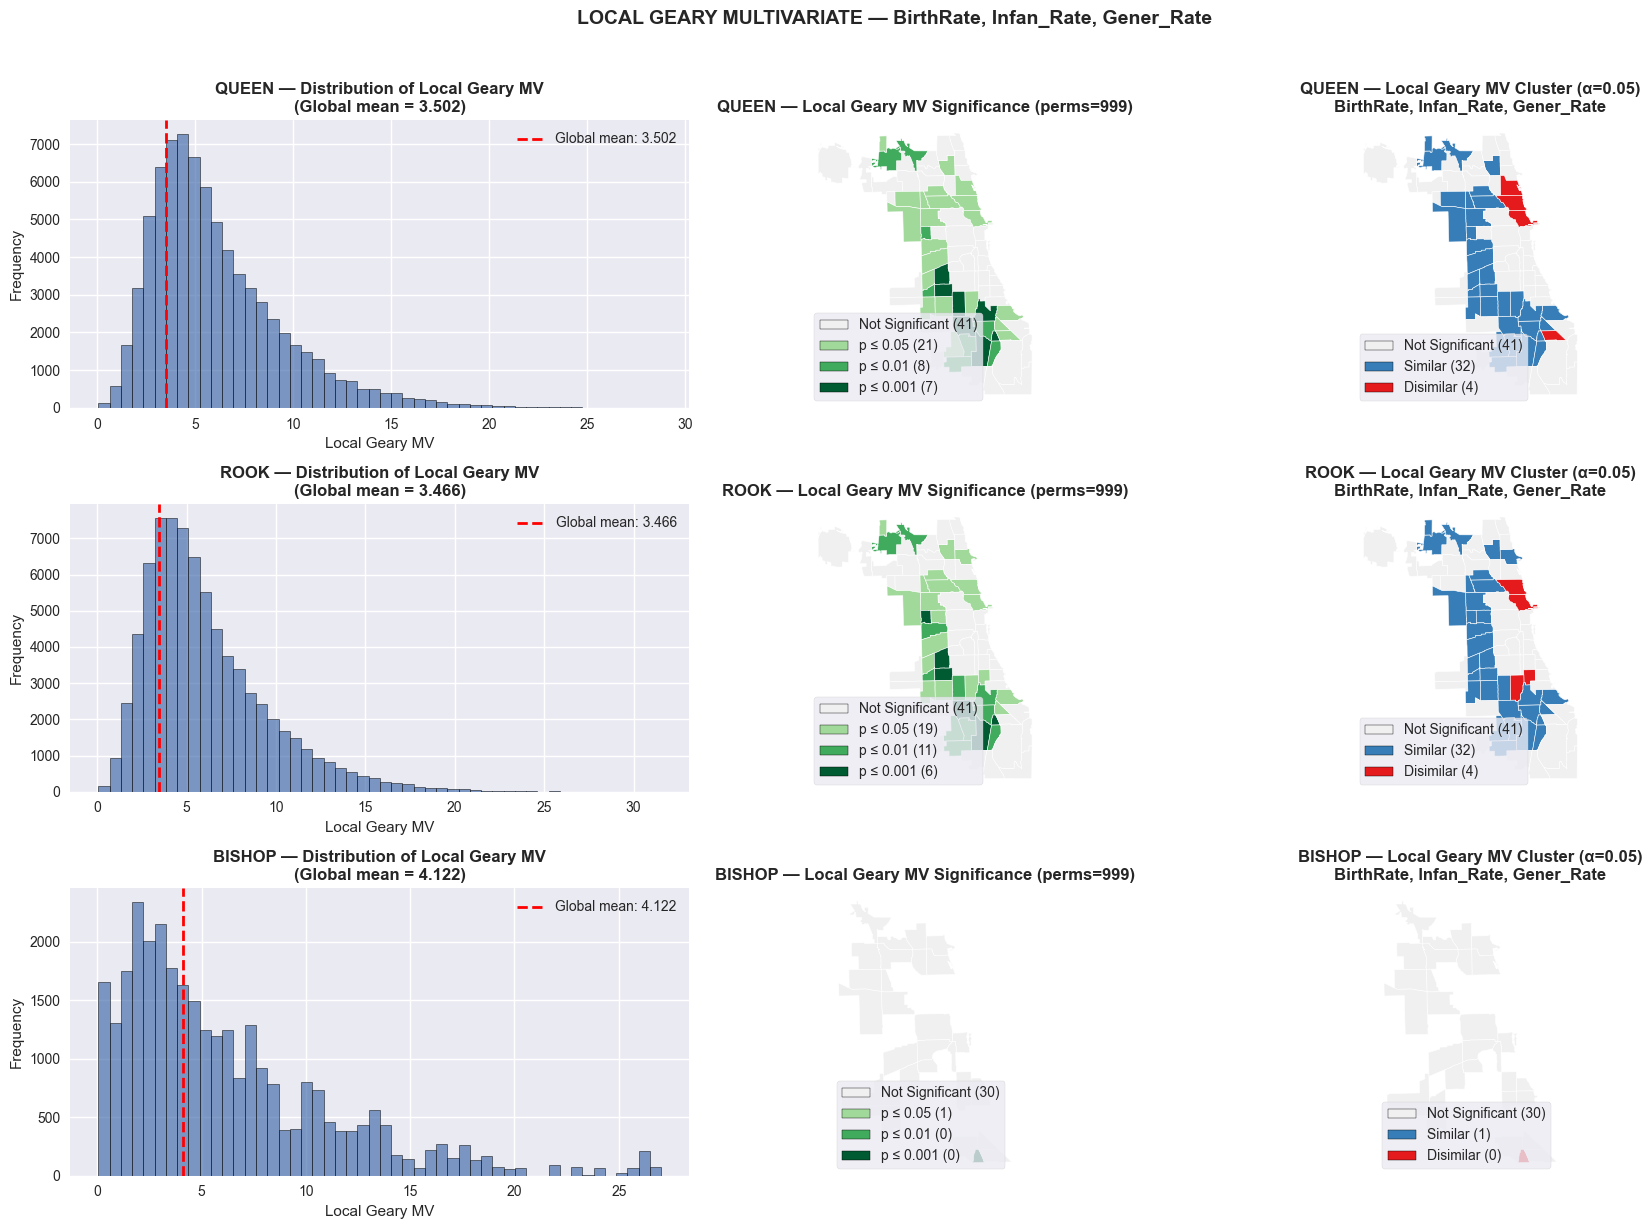

In [4]:

tab, fig, out = local_geary_mv(
    gdf=gdf,
    fields=["BirthRate", "Infan_Rate", "Gener_Rate"],  # 3 variables
    contiguities=("queen", "rook", "bishop"),
    permutations=999,
    alpha=0.05,
    standardize=True,
)

display(tab)
plt.show()